## Predicting total energies and enthalpies of formation of metal-nonmetal compounds by linear regression 

Here, we want to study the accuracy and time used to predict variable dataset sizes using the featurizations and algorithms used in [Deml et al paper](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.93.085142)

Referred to `matminer_examples/notebooks/machine-learning/predicting-formation-enthalpy-from-composition.ipynb `

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mdf_forge.forge import Forge

from matminer.data_retrieval.retrieve_MDF import MDFDataRetrieval
from matminer.utils.conversions import str_to_composition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf

from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_predict, KFold
from sklearn import metrics

from matplotlib.colors import LogNorm

### Load Training Set 

Importing OQMD data (fully ordered ionic compounds with cations from groups 1-14 and anions from groups 15-17)

In [2]:
mdf = MDFDataRetrieval(anonymous=True)

In [3]:
oqmd_version = mdf.forge.get_dataset_version('oqmd')
print ('Current version of OQMD:', oqmd_version)

Current version of OQMD: 9


Run a faster version of demo

In [4]:
quick_demo = False

Query that gets only the converged static calculations from the OQMD.

In [5]:
query_string = 'mdf.source_name:oqmd_v{0} AND (oqmd_v{0}.configuration:static OR'\
    'oqmd_v{0}.configuration:standard) AND dft.converged:True'.format(oqmd_version)
if quick_demo:
    query_string += " AND mdf.scroll_id:<10000"

In [6]:
orig_data = mdf.get_data(query_string, unwind_arrays=False)

100%|██████████| 119440/119440 [03:28<00:00, 550.00it/s]


In [7]:
print ("Shape of data:", orig_data.shape)
orig_data.head(2)

Shape of data: (119440, 29)


,crystal_structure.cross_reference.icsd,crystal_structure.number_of_atoms,crystal_structure.space_group_number,crystal_structure.volume,dft.converged,dft.cutoff_energy,dft.exchange_correlation_functional,files,material.composition,material.elements,...,oqmd_v9.delta_e.units,oqmd_v9.delta_e.value,oqmd_v9.magnetic_moment.units,oqmd_v9.magnetic_moment.value,oqmd_v9.stability.units,oqmd_v9.stability.value,oqmd_v9.total_energy.units,oqmd_v9.total_energy.value,oqmd_v9.volume_pa.units,oqmd_v9.volume_pa.value
0,53549.0,40,128,589.171,True,520.0,PBE,"[{'data_type': 'ASCII text, with very long lin...",Fe3Si5Tb2,"[Si, Tb, Fe]",...,eV/atom,-0.562432,bohr/atom,-0.000013,eV/atom,-0.053557,eV/atom,-6.824799,angstrom^3/atom,14.7293
1,NaN,20,62,287.123,True,520.0,PBE,"[{'data_type': 'ASCII text, with very long lin...",Eu1Hf1O3,"[O, Eu, Hf]",...,eV/atom,-3.496983,bohr/atom,0.000070,eV/atom,0.347291,eV/atom,-8.579549,angstrom^3/atom,14.3562


We only need two columns: `total_energy` and `material.composition`.

In [150]:
data = orig_data[['oqmd_v{}.total_energy.value'.format(oqmd_version), 'oqmd_v{}.delta_e.value'.format(oqmd_version),'material.composition']]

In [151]:
data = data.rename(columns={'oqmd_v{}.total_energy.value'.format(oqmd_version): 'total_energy', 'oqmd_v{}.delta_e.value'.format(oqmd_version): 'delta_e', 'material.composition':'composition'})

### Compile Training Set 

Get only the lower-energy entry for each composition.

In [152]:
data['composition_obj'] = str_to_composition(data['composition'])

Remove compounds without `total_energy` measurement.

In [153]:
data = data.dropna(subset=['total_energy', 'delta_e']).reset_index(drop=True)

Get only the groundstate and each composition

In [154]:
%%time
original_count = len(data)
data['mdf.composition'] = data['composition_obj'].apply(lambda x: x.reduced_formula)
data.drop_duplicates('mdf.composition', keep='first', inplace=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

/Users/AikRui/anaconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:409: UserWarning:

No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:409: UserWarning:

No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:409: UserWarning:

No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.



Removed 42176/112583 entries
CPU times: user 7.91 s, sys: 61.5 ms, total: 7.97 s
Wall time: 8.04 s


Remove outliers

In [155]:
original_count = len(data)
data = data[np.logical_and(data['total_energy'] >= -20, data['total_energy'] <= 5)].reset_index(drop=True)
data = data[np.logical_and(data['delta_e'] >= -20, data['delta_e'] <= 5)].reset_index(drop=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 13/70407 entries


Remove elements which are not used to develop model in the paper

In [156]:
%%time
el = ['H', 'Li', 'B', 'C', 'He', 'Ne', 'Ar', 
      'Br', 'Kr', 'I', 'Xe', 'Po', 'At', 'Rn', 'Tl', 
      'Cs', 'Tc', 'Ru', 'Rh', 'Pd', 'Ta', 'W', 'Re', 
      'Os', 'Ir', 'Pt', 'Pu', 'Ac', 'Np', 'U', 'Th', 
      'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd',
      'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Pa', 
      'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 
      'Lr',
      'Be', 'Pb', 'Mo']

original_count = len(data)
for i in range(data['composition'].shape[0]):
    if any (word in data['composition'][i] for word in el):
        data = data.drop([i, i]) # drop a row by index
data = data.reset_index(drop=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 63557/70394 entries
CPU times: user 9min 19s, sys: 1min 15s, total: 10min 35s
Wall time: 10min 47s


In [157]:
print ("Final shape of data:", data.shape)

Final shape of data: (6837, 5)


**Note**: Size of our data is larger than the one used in the paper.

## Build an ML model

### Part 1: Compute Representation 

Convert our raw materials data into the required input for an ML model: a finite list of quantitative attributes. In this case, we use the attributes as shown in [Deml et al 2016](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.93.085142).

In [158]:
%%time
ft = MultipleFeaturizer([cf.ElementProperty.from_preset('deml'), 
#                          cf.CationProperty.from_preset('deml'),
#                          cf.OxidationStates.from_preset('deml'),
                         cf.TMetalFraction(),
#                          cf.ElectronegativityDiff(),
                         cf.ValenceOrbital()])
data = ft.featurize_dataframe(data, col_id='composition_obj')

CPU times: user 2.65 s, sys: 386 ms, total: 3.04 s
Wall time: 9.6 s


In [159]:
print ("Shape of featurized data: ", data.shape)
data.head(1)

Shape of featurized data:  (6837, 94)


,total_energy,delta_e,composition,composition_obj,mdf.composition,minimum atom_num,maximum atom_num,range atom_num,mean atom_num,std_dev atom_num,...,std_dev FERE correction,transition metal fraction,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons
0,-8.035302,-1.367218,N7Si4Sr1Y1,"(N, Si, Sr, Y)",SrYSi4N7,7,39,32,14.0,14.027983,...,0.444131,0.0,2.0,2.230769,0.076923,0.0,0.464286,0.517857,0.017857,0.0


### Part 2: Linear Model: Stepwise Linear Regression 

Storing formation enthalpy data for later use

In [160]:
DFT_delta_e = data['delta_e']

Shuffling data

In [161]:
data = shuffle(data)

Each dataset is randomly divided into three groups: 
- 70% for training the model
- 15% for preliminary assessment (validation) of model's predictive ability
- 15% for independent assessment (testing) of model's predictive ability

In [162]:
x = data.drop(['total_energy', 'delta_e', 'composition', 'composition_obj', 'mdf.composition'], 1)
y = data['total_energy']

In [163]:
n = data.shape[0]
x_train, x_val, x_test = x[:int(n*0.7)], x[int(n*0.7):int(n*0.85)], x[int(n*0.85):]
y_train, y_val, y_test = y[:int(n*0.7)], y[int(n*0.7):int(n*0.85)], y[int(n*0.85):]

Linear regression model is used. 

In [164]:
model = LinearRegression()

### Part 3: Quantifying performance of model with different number of candidate descriptors used

Implementation of stepwise linear regression where terms (candidate descriptors) from a linear model are sequentially added or removed according to their effective significance probabilities. In the paper, this approach was implemented in [JMP](https://www.jmp.com/en_us/software/predictive-analytics-software.html). Here, we use recursive feature elimination to assign weights to features and remove features with low weightage.




10-fold cross validation was used within the training set to quantify performance of model

In [165]:
kfold = KFold(10, shuffle=True)

Number of terms (candidate descriptors) to be used

In [166]:
num_features = range(10, data.shape[1], 10)

Initializing mean absolute error, mean squared error and R2 score

In [167]:
score_train = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_val = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_test = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}

Training the linear regression model with variable number of features used and quantifying the performance. 

In [168]:
for i in num_features:
    selector = RFE(model, n_features_to_select=i, step=0.9)
    selector = selector.fit(x_train, y_train)
    cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
    cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
    cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)
    for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
        score_train[scorer].append(getattr(metrics,scorer)(y_train, cv_train))
        score_val[scorer].append(getattr(metrics,scorer)(y_val, cv_val))
        score_test[scorer].append(getattr(metrics,scorer)(y_test, cv_test))

Plot the model performance when number of terms (candidate descriptors) is changed.

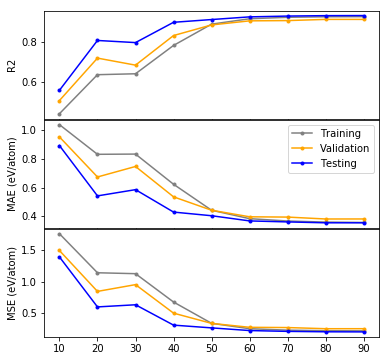

In [169]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.set_ylabel("R2")
ax2.set_ylabel("MAE (eV/atom)")
ax3.set_ylabel("MSE (eV/atom)")

ax1.plot(num_features, score_train['r2_score'], c='grey', marker='.', label='Training')
ax1.plot(num_features, score_val['r2_score'], c='orange', marker='.', label='Validation')
ax1.plot(num_features, score_test['r2_score'], c='blue', marker='.', label='Testing')

ax2.plot(num_features, score_train['mean_absolute_error'], c='grey', marker='.', label='Training')
ax2.plot(num_features, score_val['mean_absolute_error'], c='orange', marker='.', label='Validation')
ax2.plot(num_features, score_test['mean_absolute_error'], c='blue', marker='.', label='Testing')

ax3.plot(num_features, score_train['mean_squared_error'], c='grey', marker='.', label='Training')
ax3.plot(num_features, score_val['mean_squared_error'], c='orange', marker='.', label='Validation')
ax3.plot(num_features, score_test['mean_squared_error'], c='blue', marker='.', label='Testing')

ax2.legend()

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.01)

_Finding_: Around 60 terms is sufficient. 

In [170]:
selector = RFE(model, n_features_to_select=60, step=0.9)
selector = selector.fit(x_train, y_train)

In [171]:
cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)

Plot the predictions

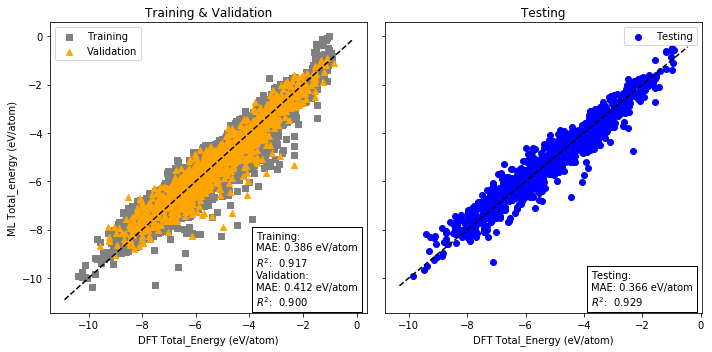

In [172]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

# Training and Validation plot
mae_train = metrics.mean_absolute_error(y_train, cv_train)
r2_train = metrics.r2_score(y_train, cv_train)
mae_val = metrics.mean_absolute_error(y_val, cv_val)
r2_val = metrics.r2_score(y_val, cv_val)
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax1.scatter(y_train, cv_train, c='grey', marker='s', label='Training')
ax1.scatter(y_val, cv_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax1.legend()

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT Total_Energy (eV/atom)')
ax1.set_ylabel('ML Total_energy (eV/atom)')

# Testing plot
mae_test = metrics.mean_absolute_error(y_test, cv_test)
r2_test = metrics.r2_score(y_test, cv_test)
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.scatter(y_test, cv_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')

ax2.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT Total_Energy (eV/atom)')

fig.set_size_inches(10, 5)
fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig('oqmd_cv.png', dpi=320)

### Prediction of formation enthalpy

In [173]:
ML_delta_e = pd.Series(index=np.arange(data.shape[0]))

Importing fitted elemental phase reference energies, $\mu^{FERE}$ from `matminer.utils.data_files.deml_elementdata`

In [174]:
from matminer.utils.data_files.deml_elementdata import mus_fere

Using total energy value to compute formation energy according to the equation 
$$\Delta H_f = E_{tot} - \Sigma_i c_i \mu_i^{FERE}$$

In [175]:
for i in range(data.shape[0]):
    fere = (float(data['composition_obj'][i][str(j)])/data['composition_obj'][i].num_atoms*mus_fere[str(j)] for j in (data['composition_obj'][i]))
    fere = sum(fere)
    ML_delta_e[i] = data['total_energy'][i] - fere

Partitioning both ML and DFT formation enthalpy data into training, validation and testing sets.

In [176]:
ML_delta_e, DFT_delta_e = shuffle(ML_delta_e, DFT_delta_e)
dft_train, dft_val, dft_test = DFT_delta_e[:int(n*0.7)], DFT_delta_e[int(n*0.7):int(n*0.85)], DFT_delta_e[int(n*0.85):]
ml_train, ml_val, ml_test = ML_delta_e[:int(n*0.7)], ML_delta_e[int(n*0.7):int(n*0.85)], ML_delta_e[int(n*0.85):]

Plot the prediction of formation enthalpy

In [177]:
mae_train = metrics.mean_absolute_error(ml_train, dft_train)
mae_val = metrics.mean_absolute_error(ml_val, dft_val)
mae_test = metrics.mean_absolute_error(ml_test, dft_test)

r2_train = metrics.r2_score(ml_train, dft_train)
r2_val = metrics.r2_score(ml_val, dft_val)
r2_test = metrics.r2_score(ml_test, dft_test)

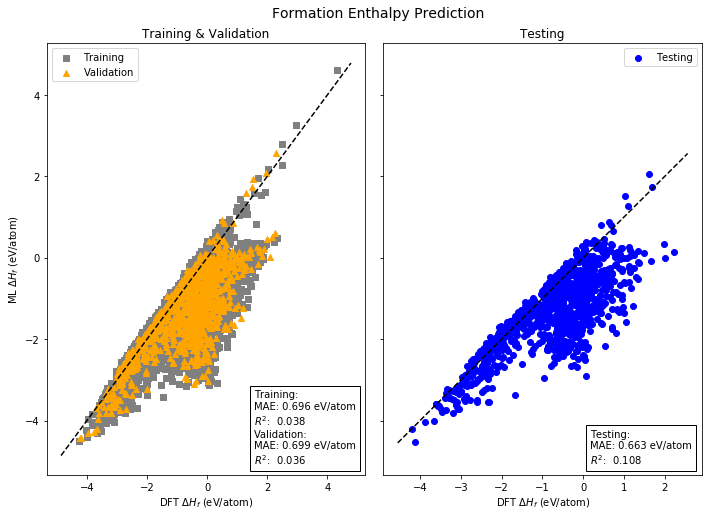

In [199]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.suptitle('Formation Enthalpy Prediction', fontsize=14, x=0.53, y=1.02)

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax1.set_ylabel('ML $\Delta H_f$ (eV/atom)')
ax1.scatter(dft_train, ml_train, c='grey', marker='s', label='Training')
ax1.scatter(dft_val, ml_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax1.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax2.scatter(dft_test, ml_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.legend()

fig.set_size_inches(10, 7)
fig.tight_layout()

***Huge error, not sure if it's correct***